# Environment

In [18]:
import numpy as np
import matplotlib.pyplot as plt
# from IPython.core.display_functions import display
from PIL import Image, ImageOps
from torchvision.transforms import Compose, Resize, ToTensor
# import cv2 as cv
from collections import deque

import torch.optim as optim
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import os
# from einops import rearrange, reduce, repeat
# from einops.layers.torch import Rearrange, Reduce
# from torchsummary import summary
# from torch.distributions import Categorical

In [19]:
def generate_cropped_im(im, cropped_dims):
    h_shift = 10
    s_shift = 10
    v_shift = 51
    # generate random crop shifts
    crop_attributes = {}
    cropped_shift = [np.random.randint(0,im.size[0]-cropped_dims[0]),np.random.randint(0,im.size[1]-cropped_dims[1])]
    # cropped_shift = [37,37]
    crop_coords = (cropped_shift[0], cropped_shift[1], cropped_shift[0]+cropped_dims[0], cropped_shift[1]+cropped_dims[1])
    cropped_im = im.crop(crop_coords)
    cropped_im = cropped_im.convert('HSV')
    h, s, v = cropped_im.split()
    h = h.point(lambda p: p + h_shift)
    s = s.point(lambda p: p + s_shift)
    v = v.point(lambda p: p + v_shift)
    cropped_im = Image.merge('HSV', (h, s, v))
    cropped_im = cropped_im.convert('RGB')
    cropped_im_shape = cropped_im.size
    crop_attributes['crop_coords'] = crop_coords
    crop_attributes['cropped_shift'] = cropped_shift
    crop_attributes['cropped_im'] = cropped_im
    crop_attributes['cropped_im_shape'] = cropped_im_shape
    
    return crop_attributes

In [76]:
class Env:
    def __init__(self, fixed_image, moving_image, crop_coords=(37, 37, 74, 74)):
        self.crop_coords = crop_coords
        self.fixed_image = fixed_image
        self.moving_image = moving_image
        self.fixed_x = fixed_image.size[0]
        self.fixed_y = fixed_image.size[1]
        self.crop_x = crop_coords[0]
        self.crop_y = crop_coords[1]
        self.shift_x = 0
        self.shift_y = 0
        self.x_limit = fixed_image.size[0] - moving_image.size[0]
        self.y_limit = fixed_image.size[1] - moving_image.size[1]
        self.env_image = fixed_image.copy()
        self.env_image.paste(moving_image, (0,0))
        self.action_space = 4
        self.best_reward = -self.fixed_x

#     def reset(self):
#         # move image to a random position
#         print(self.x_limit)
#         self.shift_x = np.random.randint(0, self.x_limit)
#         self.shift_y = np.random.randint(0, self.y_limit)
#         self.env_image = self.fixed_image.copy()
#         self.env_image.paste(self.moving_image, (self.shift_x, self.shift_y))
#         return self.env_image
    
    def reset(self):
        crop_attr = generate_cropped_im(self.fixed_image, [37,37])
        self.crop_coords = crop_attr['crop_coords']
        print(f"Crop coords: {self.crop_coords}")
        self.moving_image = crop_attr['cropped_im']
        self.crop_x = self.crop_coords[0]
        self.crop_y = self.crop_coords[1]
        self.x_limit = self.fixed_image.size[0] - self.moving_image.size[0]
        self.y_limit = self.fixed_image.size[1] - self.moving_image.size[1]
        # move image to a random position
        print(self.x_limit)
        self.shift_x = np.random.randint(0, self.x_limit)
        self.shift_y = np.random.randint(0, self.y_limit)
        self.env_image = self.fixed_image.copy()
        self.env_image.paste(self.moving_image, (self.shift_x, self.shift_y))
        
        return self.env_image

    def check_frame(self, _im):
        _im_shape = _im.size
        _im_shape = [_im_shape[0] - 1, _im_shape[1] - 1]
        # check bottom border
        for i in range(_im_shape[0]):
            px = _im.getpixel((i, 0))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check top border
        for i in range(_im_shape[0]):
            px = _im.getpixel((i, _im_shape[1]))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check left border
        for i in range(_im_shape[1]):
            px = _im.getpixel((0, i))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check right border
        for i in range(_im_shape[1]):
            px = _im.getpixel((_im_shape[0], i))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        return True

    def move_image(self, _x, _y):
        EDGE_PENALTY = 0
        shift_x = int(self.shift_x + _x)
        shift_y = int(self.shift_y + _y)
        # shift_x = _x
        # shift_y = _y
        # check if image can be moved
        reward_bonus = 0
        if shift_x > self.x_limit:
            shift_x = self.x_limit
            reward_bonus -= EDGE_PENALTY
            # print('x limit reached')
        elif shift_x < 0:
            shift_x = 0
            reward_bonus -= EDGE_PENALTY
            # print('x limit reached')
        if shift_y > self.y_limit:
            shift_y = self.y_limit
            reward_bonus -= EDGE_PENALTY
            # print('y limit reached')
        elif shift_y < 0:
            shift_y = 0
            reward_bonus -= EDGE_PENALTY
            # print('y limit reached')
        if shift_x < 0 or shift_y < 0:
            print(f"Image can't be moved to {shift_x}, {shift_y}")
            return self.env_image, self.get_reward()
        self.shift_x = shift_x
        self.shift_y = shift_y
        env_copy = self.fixed_image.copy()
        env_copy.paste(self.moving_image, (shift_x, shift_y))
        self.env_image = env_copy
        reward = self.get_reward()
        # print(f"shift x {shift_x}, shift y {shift_y}, moved x {_x}, moved y {_y} moved x {self.crop_x}, moved y {self.crop_y}, reward {reward}")
        return env_copy, reward

    def get_reward(self):
        distance = np.sqrt((self.shift_x - self.crop_x)**2 + (self.shift_y - self.crop_y)**2)
        return -distance

    def get_target(self, shift_x, shift_y):
        _x = self.crop_x - shift_x
        _y = self.crop_y - shift_y
        target_x = 0.5+(_x/(2*self.x_limit))
        target_y = 0.5+(_y/(2*self.y_limit))
        return target_x, target_y

    def get_pred_target(self, pred):
        shift_x = (pred[0]*2-1) * self.x_limit
        shift_y = (pred[1]*2-1) * self.y_limit
        _x = self.crop_x - shift_x
        _y = self.crop_y - shift_y
        pred_target_x = 0.5+(_x/(2*self.x_limit))
        pred_target_y = 0.5+(_y/(2*self.y_limit))
        return pred_target_x, pred_target_y
        # return _x, _y

    def move_image_old(self, x, y):
        # move image using pil
        new_im = self.moving_image.transform(self.moving_image.size, Image.AFFINE, (1, 0, x, 0, 1, y))
        can_move = self.check_frame(new_im)
        if can_move:
            self.moving_image = new_im
            return new_im
        else:
            return self.moving_image

    def step(self, action, amount=1):
        """
        action: 0 = left, 1 = right, 2 = up, 3 = down
        """
        print(f"Action shape: {np.shape(action)}")
        if action == 0:
            new_im, reward = self.move_image(amount, 0)
        elif action == 1:
            new_im, reward = self.move_image(0, amount)
        elif action == 2:
            new_im, reward = self.move_image(-amount, 0)
        elif action == 3:
            new_im, reward = self.move_image(0, -amount)

        if reward >= -1:
            reward = (self.fixed_image.size[0] + 100)
            return new_im, reward, True
        else:
            return new_im, (reward), False

In [77]:
def preprocess_data(path, display=True):
    h_shift = 0
    s_shift = 0
    v_shift = 0
    envs = []
    for i, filename in enumerate(os.listdir(path)):
        if filename.endswith(".jpg"):
            if i == 100:
                break
            im = Image.open('/'.join([path, filename]))
            im_shape = im.size
            if im_shape[0] >= 112 and im_shape[1] >= 112:
                im_scale_x = im_shape[0]/112
                im_scale_y = im_shape[1]/112

                scale = 1/2
                im = im.resize((int(im_shape[0]/im_scale_x),int(im_shape[1]/im_scale_y)),Image.ANTIALIAS)
                im_shape = im.size
                im = im.crop((0, 0, 112, 112))
                im_shape = im.size
                cropped_dims = [37, 37]
                crop_attr = generate_cropped_im(im, cropped_dims)
                cropped_im = crop_attr['cropped_im']
                # change cropped image hue
                cropped_im = cropped_im.convert('HSV')
                cropped_im_shape = crop_attr['cropped_im_shape']
                print(f'im_shape: {im_shape}, cropped_im_shape: {cropped_im_shape}')
                crop_coords = crop_attr['crop_coords']

                # red_dot = Image.new('RGB', (10, 10), color = 'red')
                # green_dot = Image.new('RGB', (10, 10), color = 'green')
                env_im = im
                # cropped_im.paste(red_dot, (0,0))
                fixed_x = crop_coords[0]
                fixed_y = crop_coords[1]
                shift_x = im_shape[0] - cropped_im_shape[0]
                shift_y = 0

                fixed = (fixed_x, fixed_y)
                moving = (shift_x, shift_y)

                distance = np.sqrt((fixed[0] - moving[0])**2 + (fixed[1] - moving[1])**2)

                # env_im.paste(cropped_im, (shift_x, shift_y))
                # env_im.paste(green_dot, (fixed_x, fixed_y))
                env = Env(im, cropped_im, crop_coords)
                envs.append(env)
                print(f'image: {path},  distance: {distance}')
                im2 = im.copy()
                if display:
                    plt.imshow(im2)
                    plt.show()
                    plt.imshow(cropped_im)
                    plt.show()
                # resize to imagenet size
                transform = Compose([Resize((112, 112)), ToTensor()])
                x = transform(im)
                x = x.unsqueeze(0) # add batch dim
                x.shape
    return envs

In [78]:
envs = preprocess_data('coffee', display=False)

im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 50.99019513592785
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.907327887774215
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.85164807134504
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 27.85677655436824
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 53.33854141237835
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 50.00999900019995
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 41.43669871020132
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 68.62215385719105
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 75.4254598925323
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 99.70456358662827
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  dista

/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  app.launch_new_instance()


In [79]:
device = torch.device("cuda")
print(device)

env = envs[1]

cuda


Crop coords: (29, 48, 66, 85)
75
Reward: -46.14108798023731


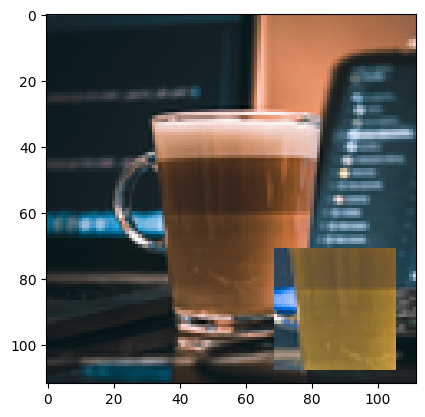

-40 -23
-0.0


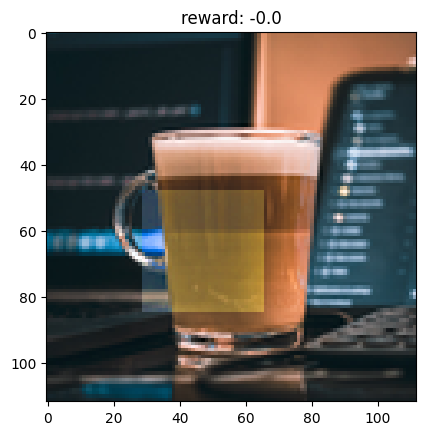

In [80]:
im_b = env.reset()
reward = env.get_reward()
print(f"Reward: {reward}")
plt.imshow(im_b)
plt.show()
# print(f"shift coords: {env.shift_x}, {env.shift_y}")
# print(f"moving coords: {env.crop_x}, {env.crop_y}")
# print(f"diff: {env.crop_x-env.shift_x}, {env.crop_y-env.shift_y}")
targets = env.get_pred_target([0.5+(env.shift_x/(2*env.x_limit)),0.5+(env.shift_y/(2*env.y_limit))])
print(env.crop_x-env.shift_x+0 ,env.crop_y - env.shift_y+0)
im_a, r = env.move_image(env.crop_x-env.shift_x ,env.crop_y - env.shift_y)
print(r)
plt.imshow(im_a)
plt.title(f'reward: {r}')
plt.show()

# utils

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

# ppo_torch

In [106]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import torchvision.transforms as TR

resize = TR.Compose([TR.ToPILImage(),
                    TR.Resize(112, interpolation=Image.CUBIC),
                    TR.ToTensor()])

def transform_obs(observation):
        observation = np.ascontiguousarray(observation, dtype=np.float32) / 255
        observation = torch.from_numpy(observation)
        observation = resize(observation.T)
        observation = observation.unsqueeze(0)

        return observation

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []


class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            size = (size - (kernel_size - 1) - 1) // stride  + 1
            return size

        self.convw = conv2d_size_out(conv2d_size_out(112))
        self.convh = conv2d_size_out(conv2d_size_out(112))
        self.linear_input_size = self.convw * self.convh * 32
        print(f"## {self.linear_input_size}")
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=5, stride=2),
                nn.GroupNorm(16,16),
                nn.ReLU(),
                nn.Conv2d(16, 32, kernel_size=5, stride=2),
                nn.GroupNorm(32,32),
                nn.ReLU(),
                nn.Linear(24, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        print(f"dist sum: {dist.shape}")
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        self.convw = conv2d_size_out(conv2d_size_out(112))
        self.convh = conv2d_size_out(conv2d_size_out(112))
        self.linear_input_size = self.convw * self.convh * 32
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=5, stride=2),
                nn.GroupNorm(16,16),
                nn.ReLU(),
                nn.Conv2d(16, 32, kernel_size=5, stride=2),
                nn.GroupNorm(32,32),
                nn.ReLU(),
                nn.Linear(25, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):

        state = transform_obs(observation)
        state = T.tensor(state, dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        probs = T.squeeze(log_prob).item()
        actions = T.squeeze(action).item()
        values = T.squeeze(value).item()

        return actions, probs, values

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               



/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  # Remove the CWD from sys.path while we load stuff.


# Main

In [105]:
# import gym
import numpy as np
import random

if __name__ == '__main__':
    env = random.choice(envs)
    N = 20
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003
    agent = Agent(n_actions=4, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=[3,112,112])
    n_games = 300

    figure_file = 'plots/cartpole.png'

    best_score = env.best_reward
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done = env.step(action)
            if reward > env.best_reward:
                env.best_reward = reward
            n_steps += 1
            score += reward
            agent.remember(transform_obs(observation), action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)



## 20000
Crop coords: (35, 52, 72, 89)
75
dist sum: torch.Size([1, 32, 25, 4])


/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ValueError: only one element tensors can be converted to Python scalars

In [15]:
! mkdir tmp/ddpg/Actor_ddpg